In [28]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [58]:
rootdir = os.getcwd()
os.chdir(rootdir)

In [59]:
gyrFile = 'Gyroscope'
accFile = 'Accelerometer'

normal = 'normal'

upstairs = 'upstairs'
downstairs = 'downstairs'

s1 = 'Smartphone1'
s2 = 'Smartphone2'
s3 = 'Smartphone3'
s4 = 'Smartphone4'

# defining an array for gyroscope data
dataAss = []

In [61]:
for subdir, dirs, files in os.walk(rootdir):
    if s1 in subdir:
        if normal in subdir:
            for file in files:
                if gyrFile in file:
                    print(os.path.join(subdir, file))
                    with open(os.path.join(subdir, file), 'r') as f: # open in read-only mode
                        gyrData = pd.read_csv(f)
                        gyrTime = gyrData['Time (s)']
                        gyrX = gyrData['X (rad/s)']
                        gyrY = gyrData['Y (rad/s)']
                        gyrZ = gyrData['Z (rad/s)']
                        gyrShape = gyrData.shape
                    
                        freqGyr = 1/(gyrTime[1]-gyrTime[0])
                        
                        # Assemble the data into a tensor
                        dataAss.append(gyrData)

                        # print("Frequency of Gyroscope: ", freqGyr)
                        # print(gyrShape)
                        
#End of file data import and processing

d:\OneDrive - rwth-aachen.de\EDU_Master\1 Courses\ws21\Computational Intelligence in Engineering (VO) [21ws-41.09212]\_Project\CIE7\SensorData\Smartphone1\subject181_normal01\Gyroscope.csv
d:\OneDrive - rwth-aachen.de\EDU_Master\1 Courses\ws21\Computational Intelligence in Engineering (VO) [21ws-41.09212]\_Project\CIE7\SensorData\Smartphone1\subject181_normal02\Gyroscope.csv


0        0.025046
1        0.035056
2        0.045066
3        0.055075
4        0.065085
          ...    
2991    29.964686
2992    29.974696
2993    29.984707
2994    29.994717
2995    30.004727
Name: Time (s), Length: 2996, dtype: float64

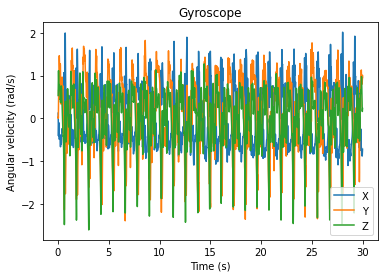

In [11]:
def plot():
    plt.plot(gyrTime, gyrX, label='X')
    plt.plot(gyrTime, gyrY, label='Y')
    plt.plot(gyrTime, gyrZ, label='Z')

    plt.xlabel('Time (s)')
    plt.ylabel('Angular velocity (rad/s)')
    plt.title('Gyroscope_Normal')
    plt.legend()
    plt.show()

plot()

In [55]:
dataAss[0]['Time (s)']

NameError: name 'dataAss' is not defined